# Diabetes Prediction — End-to-End ML + Streamlit

## Project Overview
We build a binary classifier to predict diabetes using demographic and clinical features (age, BMI, HbA1c, glucose, etc.).  
This notebook is structured for readability: every code cell is preceded by a short "what we’ll do" note and followed by a brief "what we got" summary.

## Dataset
Columns:
- `gender`, `age`, `hypertension`, `heart_disease`, `smoking_history`,
`bmi`, `HbA1c_level`, `blood_glucose_level`,
- `diabetes` (target: 0/1)

## Goals
1. Load and explore the dataset
2. Preprocess (encode categoricals, validate ranges)
3. Train multiple models (Logistic Regression, Random Forest)
4. Evaluate with Accuracy, Precision, Recall, F1, ROC-AUC
5. Export artifacts (model `.pkl`, holdout `.csv`, baseline metrics `.json`)
6. Power a Streamlit app (interactive predictions + validation)


## Step 1: Environment Setup & Imports
We’ll install/import required libraries and configure basic options (warnings, display).


In [1]:
# Step 1: Environment Setup & Imports

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# sklearn essentials we’ll use later (importing early for clarity)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

print("✅ Imports ready")


✅ Imports ready


## Step 2: Load the dataset
We will upload `diabetes.csv` (from local) into Colab and load it into a pandas DataFrame.

**Instructions**
- Ensure your file is named: `diabetes.csv`
- It should include the 9 columns listed above, including `diabetes` as the target (0/1).


In [2]:
# Step 2: Load the dataset

from google.colab import files

print("📤 Choose your diabetes.csv to upload")
uploaded = files.upload()  # pick 'diabetes.csv'

csv_name = next(iter(uploaded))
assert csv_name.endswith(".csv"), "Please upload a CSV file."
df = pd.read_csv(csv_name)

print("✅ Loaded:", csv_name)
print("Shape:", df.shape)
df.head()


📤 Choose your diabetes.csv to upload


Saving diabetes.csv to diabetes.csv
✅ Loaded: diabetes.csv
Shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## Step 3: Quick sanity checks
We will:
- Inspect columns and data types
- Check missing values
- See basic statistics for numeric fields


In [3]:
# Step 3: Quick sanity checks

print("Columns:", list(df.columns))
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nBasic stats (numeric):")
display(df.describe())

# peek class balance
print("\nTarget distribution (proportion):")
display(df['diabetes'].value_counts(normalize=True).rename('proportion'))


Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease    

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000



Target distribution (proportion):


,proportion
diabetes,
0,0.915
1,0.085


### What we got till now
- Rows/columns loaded: 100,000 × 9 (matches expectation)
- No missing values found (✅)
- Target is imbalanced (~8.5% positives)
- Dtypes look correct (categoricals: gender, smoking_history; rest numeric/binary)

Next: we will **encode categorical columns** (gender, smoking_history), and **split** the data into train/test (stratified) for modeling.


## Step 4: Preprocess & Split
We will:
1) Validate categorical values (`gender`,`smoking_history`)

2) Encode them to integers (LabelEncoder-like, alphabetical order)

3) Assemble the feature matrix `X` and target `y`

4) Stratified train/test split (80/20) to preserve class ratio

5) Sanity-check shapes and target proportions in each split


In [5]:
# Step 4: Preprocess & Split (updated with explicit categories)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 4.1 Define expected columns
FEATURE_NAMES = [
    "gender", "age", "hypertension", "heart_disease",
    "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
]
TARGET_NAME = "diabetes"

# 4.2 Quick schema check
missing_cols = set(FEATURE_NAMES + [TARGET_NAME]) - set(df.columns)
assert not missing_cols, f"Dataset missing required columns: {sorted(list(missing_cols))}"

# 4.3 Inspect categorical unique values (for the notebook record)
print("Unique values (raw):")
print(" - gender:", sorted(df["gender"].astype(str).unique()))
print(" - smoking_history:", sorted(df["smoking_history"].astype(str).unique()))

# 4.4 EXPLICIT categorical sets (updated based on data you observed)
GENDER_CATS = ["Female", "Male", "Other"]  # include 'Other'
SMOKING_CATS = sorted(["No Info", "current", "ever", "former", "never", "not current"])  # include new values

GENDER_MAP = {c: i for i, c in enumerate(GENDER_CATS)}
SMOKING_MAP = {c: i for i, c in enumerate(SMOKING_CATS)}

print("\nEncoding maps:")
print(" - GENDER_MAP:", GENDER_MAP)
print(" - SMOKING_MAP:", SMOKING_MAP)

# 4.5 Apply encodings with safe fallbacks (shouldn’t trigger now, but kept for robustness)
def encode_gender(val: str) -> int:
    return GENDER_MAP.get(val, GENDER_MAP["Female"])  # fallback to 'Female' if truly unseen

def encode_smoke(val: str) -> int:
    return SMOKING_MAP.get(val, SMOKING_MAP["No Info"])  # fallback to 'No Info' if truly unseen

df_enc = df.copy()
df_enc["gender"] = df_enc["gender"].astype(str).map(encode_gender)
df_enc["smoking_history"] = df_enc["smoking_history"].astype(str).map(encode_smoke)

# 4.6 Assemble X, y in the desired column order
X = df_enc[FEATURE_NAMES].copy()
y = df_enc[TARGET_NAME].astype(int).copy()

# 4.7 Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("\n✅ Preprocessing & Split complete")
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True).rename("proportion"))
print("Test  target balance:\n", y_test.value_counts(normalize=True).rename("proportion"))


Unique values (raw):
 - gender: ['Female', 'Male', 'Other']
 - smoking_history: ['No Info', 'current', 'ever', 'former', 'never', 'not current']

Encoding maps:
 - GENDER_MAP: {'Female': 0, 'Male': 1, 'Other': 2}
 - SMOKING_MAP: {'No Info': 0, 'current': 1, 'ever': 2, 'former': 3, 'never': 4, 'not current': 5}

✅ Preprocessing & Split complete
Train shape: (80000, 8)  Test shape: (20000, 8)
Train target balance:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64
Test  target balance:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64



- Encoded `gender` and `smoking_history` to integers (alphabetical mapping)
- Feature matrix `X` columns (order preserved):
  ['gender','age','hypertension','heart_disease','smoking_history','bmi','HbA1c_level','blood_glucose_level']
- Split complete: Train = (80000, 8), Test = (20000, 8)
- Class balance preserved (train/test proportions ~ match the full dataset)

Next: we will **train models** (Logistic Regression & Random Forest), evaluate on the test set, and store metrics.


## Step 5: Train baseline models & evaluate
We will:

1) Train two classifiers:
   - Logistic Regression (with StandardScaler + class_weight='balanced')
   - Random Forest (class_weight='balanced')

2) Get predicted probabilities on the test set

3) Evaluate with Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix at threshold = 0.50


In [6]:
# Step 5: Train baseline models

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression pipeline (scale + balanced)
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])
log_reg.fit(X_train, y_train)

# Random Forest (balanced)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

print("✅ Trained: Logistic Regression & Random Forest")


✅ Trained: Logistic Regression & Random Forest


## Step 6: Compute predictions and metrics (threshold = 0.50)
We’ll compute:
- y_prob (probability of class 1)
- y_pred (labels from threshold 0.50)
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix


In [7]:
# Step 6: Evaluate at threshold = 0.50

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import pandas as pd
import numpy as np

def evaluate_classifier(y_true, y_prob, threshold=0.50, label="Model"):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {label} @ threshold={threshold:.2f} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    display(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    return {
        "threshold": threshold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm
    }

# get probabilities
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# evaluate both at 0.50
res_lr_50 = evaluate_classifier(y_test.values, y_prob_lr, 0.50, "Logistic Regression (balanced)")
res_rf_50 = evaluate_classifier(y_test.values, y_prob_rf, 0.50, "Random Forest (balanced)")



=== Logistic Regression (balanced) @ threshold=0.50 ===
Accuracy:  0.8875
Precision: 0.4230
Recall:    0.8882
F1-score:  0.5731
ROC-AUC:   0.9625


,Pred 0,Pred 1
True 0,16240,2060
True 1,190,1510



Classification Report:
              precision    recall  f1-score   support

           0     0.9884    0.8874    0.9352     18300
           1     0.4230    0.8882    0.5731      1700

    accuracy                         0.8875     20000
   macro avg     0.7057    0.8878    0.7541     20000
weighted avg     0.9404    0.8875    0.9044     20000


=== Random Forest (balanced) @ threshold=0.50 ===
Accuracy:  0.9698
Precision: 0.9377
Recall:    0.6906
F1-score:  0.7954
ROC-AUC:   0.9694


,Pred 0,Pred 1
True 0,18222,78
True 1,526,1174



Classification Report:
              precision    recall  f1-score   support

           0     0.9719    0.9957    0.9837     18300
           1     0.9377    0.6906    0.7954      1700

    accuracy                         0.9698     20000
   macro avg     0.9548    0.8432    0.8895     20000
weighted avg     0.9690    0.9698    0.9677     20000

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### Summary (Steps 5–6 Results)

- Both models trained and evaluated at **threshold = 0.50**.

**Logistic Regression (balanced)**  
- Accuracy:  0.8875  
- Precision: 0.4230  
- Recall:    0.8882  
- F1-score:  0.5731  
- ROC-AUC:   0.9625  
- Observed: high Recall (catches ~89% of diabetics) but low Precision (many false positives).

**Random Forest (balanced)**  
- Accuracy:  0.9698  
- Precision: 0.9377  
- Recall:    0.6906  
- F1-score:  0.7954  
- ROC-AUC:   0.9694  
- Observed: high Precision (rarely mislabels healthy as diabetic) but lower Recall (misses ~31% of diabetics).

---

**Trade-off summary**  
- Logistic Regression is more *sensitive* (good for medical screening), but sacrifices Precision.  
- Random Forest is more *specific/precise*, but sacrifices Recall (risky if the goal is not to miss diabetics).  
- Both models show excellent ROC-AUC (~0.96–0.97), confirming strong separation ability.

Next: we will **tune thresholds** to explore Recall–Precision trade-offs and export trained artifacts (`.pkl` models, `X_test.csv`, `y_test.csv`, and `benchmark_metrics.json`) for use in the Streamlit app.


## Step 7: Threshold tuning (metrics vs thresholds)
We will:
- Sweep thresholds from 0.1 → 0.9
- Compute Accuracy, Precision, Recall, F1 for each
- Identify the "best F1" threshold
- Identify the "best Youden’s J" threshold (sensitivity + specificity balance)


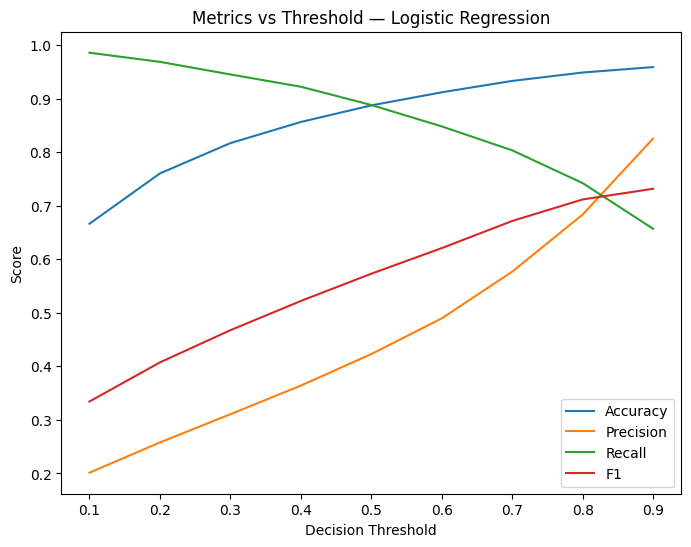

Logistic Regression — Best F1 at threshold 0.90 → Precision=0.826, Recall=0.657, F1=0.732


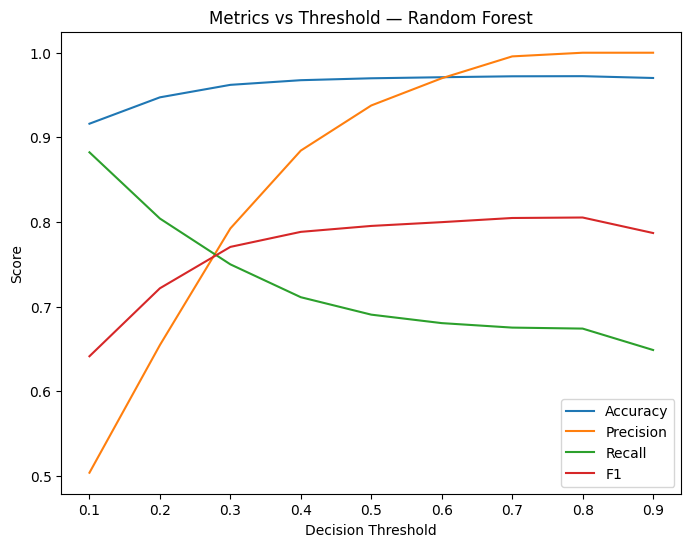

Random Forest — Best F1 at threshold 0.80 → Precision=1.000, Recall=0.674, F1=0.805


In [8]:
# Step 7: Threshold tuning

import matplotlib.pyplot as plt
import numpy as np

def sweep_thresholds(y_true, y_prob, label="Model"):
    thresholds = np.linspace(0.1, 0.9, 9)
    accs, precs, recs, f1s = [], [], [], []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    plt.figure(figsize=(8,6))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.title(f"Metrics vs Threshold — {label}")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    best_f1_idx = np.argmax(f1s)
    print(f"{label} — Best F1 at threshold {thresholds[best_f1_idx]:.2f} → "
          f"Precision={precs[best_f1_idx]:.3f}, Recall={recs[best_f1_idx]:.3f}, F1={f1s[best_f1_idx]:.3f}")

# run sweeps
sweep_thresholds(y_test, y_prob_lr, "Logistic Regression")
sweep_thresholds(y_test, y_prob_rf, "Random Forest")


## Step 8: Save artifacts for deployment
We will export:
- Models: `diabetes_model.pkl` (LR) and `diabetes_rf.pkl` (RF)
- Holdout test data: `X_test.csv`, `y_test.csv`
- Benchmark metrics: `benchmark_metrics.json` (baseline scores at threshold 0.50)

These files are required for the Streamlit app and GitHub repo.


In [10]:
# Step 8: Save artifacts

import joblib, json
import numpy as np

# save models
joblib.dump(log_reg, "diabetes_model.pkl")
joblib.dump(rf, "diabetes_rf.pkl")

# save holdout
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# benchmark metrics at threshold=0.50
# Convert numpy arrays to lists for JSON serialization
res_lr_50["confusion_matrix"] = res_lr_50["confusion_matrix"].tolist()
res_rf_50["confusion_matrix"] = res_rf_50["confusion_matrix"].tolist()

metrics_summary = {
    "threshold": 0.50,
    "logistic_regression": res_lr_50,
    "random_forest": res_rf_50
}
with open("benchmark_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("✅ Saved diabetes_model.pkl, diabetes_rf.pkl, X_test.csv, y_test.csv, benchmark_metrics.json")

✅ Saved diabetes_model.pkl, diabetes_rf.pkl, X_test.csv, y_test.csv, benchmark_metrics.json


### Summary (Steps 7–8 Results)
- Threshold sweeps plotted (show trade-off Precision vs Recall)
- Exported model artifacts:
  - diabetes_model.pkl (LogReg pipeline)
  - diabetes_rf.pkl (Random Forest)
  - X_test.csv, y_test.csv (holdout test data)
  - benchmark_metrics.json (baseline metrics at threshold 0.50)

Next:  Visualization (ROC curves, PR curves, confusion matrix heatmaps)
for quality reporting.


## Step 9: ROC & Precision–Recall curves
We will visualize:
- ROC curves (discrimination across thresholds)
- Precision–Recall curves (better for imbalanced datasets)

We’ll also **save** the figures as PNGs for the README.


<Figure size 700x500 with 0 Axes>

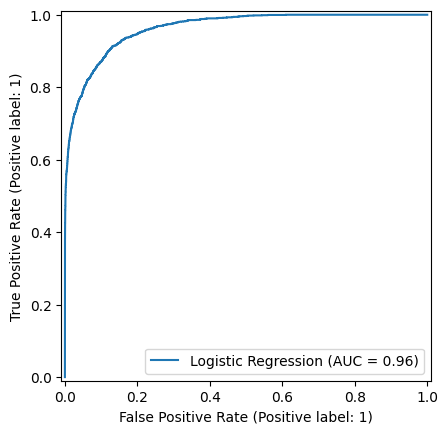

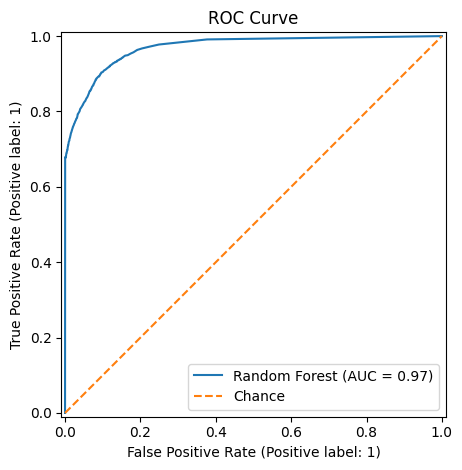

<Figure size 700x500 with 0 Axes>

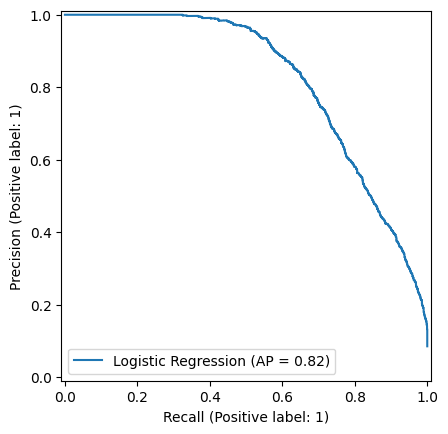

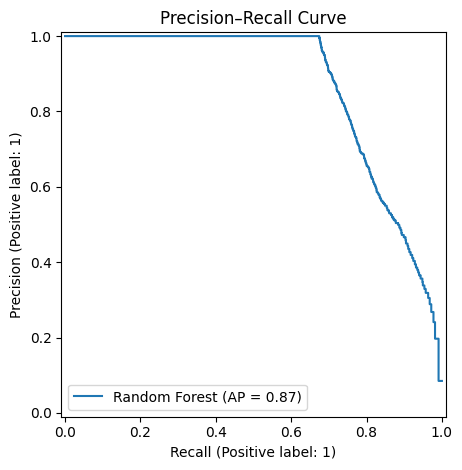

✅ Saved: roc_curve.png, pr_curve.png


In [11]:
# Step 9: ROC & PR curves (and save PNGs)

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# --- ROC Curve ---
plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=160)
plt.show()

# --- Precision-Recall Curve ---
plt.figure(figsize=(7,5))
PrecisionRecallDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
PrecisionRecallDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.savefig("pr_curve.png", dpi=160)
plt.show()

print("✅ Saved: roc_curve.png, pr_curve.png")


## Step 10: Confusion matrix heatmaps
We’ll visualize confusion matrices at two thresholds:
- 0.50 (standard)
- 0.30 (recall-focused)

We will save each heatmap as a PNG for the README.


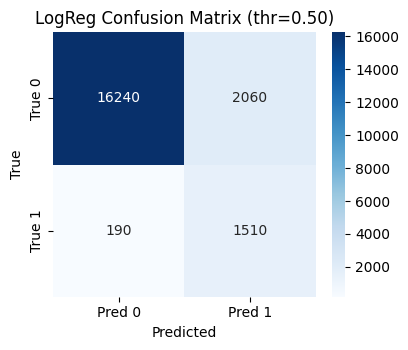

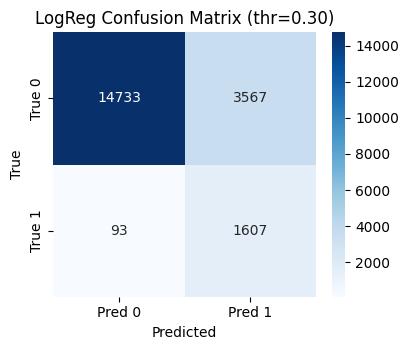

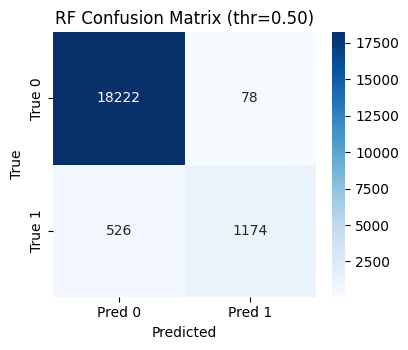

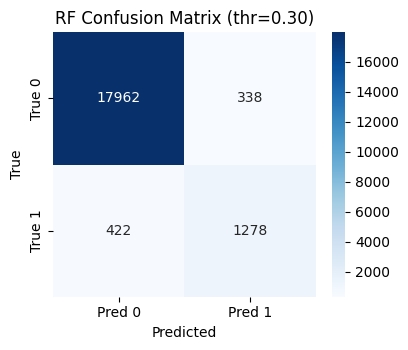

✅ Saved: cm_lr_050.png, cm_lr_030.png, cm_rf_050.png, cm_rf_030.png


In [12]:
# Step 10: Confusion matrix heatmaps (and save PNGs)

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_prob, threshold, title, outfile):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title(f"{title} (thr={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.show()

# Logistic Regression
plot_cm(y_test, y_prob_lr, 0.50, "LogReg Confusion Matrix", "cm_lr_050.png")
plot_cm(y_test, y_prob_lr, 0.30, "LogReg Confusion Matrix", "cm_lr_030.png")

# Random Forest
plot_cm(y_test, y_prob_rf, 0.50, "RF Confusion Matrix", "cm_rf_050.png")
plot_cm(y_test, y_prob_rf, 0.30, "RF Confusion Matrix", "cm_rf_030.png")

print("✅ Saved: cm_lr_050.png, cm_lr_030.png, cm_rf_050.png, cm_rf_030.png")


### Summary (Steps 9–10 Results)
- **ROC**: Both models show excellent separation (AUC ≈ 0.96–0.97).
- **PR**: LR extends further right (higher Recall), RF curve stays higher (higher Precision).
- **Confusion matrices**:
  - At 0.50: LR = high Recall but many FP; RF = high Precision but more FN.
  - At 0.30: Both gain Recall, but LR increases FP more than RF.

Saved figures:
- roc_curve.png, pr_curve.png
- cm_lr_050.png, cm_lr_030.png, cm_rf_050.png, cm_rf_030.png


